The objective of this notebook is to use historical loan application data to predict whether or not an applicant will be able to repay a loan. This is a standard supervised classification task:

- **Supervised**: The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features
- **Classification**: The label is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan)

### Data
The data is provided by Home Credit, a service dedicated to provided lines of credit (loans) to the unbanked population.

There are 7 different sources of data:

- **application_train/application_test**: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.

- **bureau**: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.

- **bureau_balance**: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.

- **previous_application**: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.

- **POS_CASH_BALANCE**: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.

- **credit_card_balance**: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.

- **installments_payment**: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

### Metric: ROC AUC

In this case, it is a common classification metric known as the Receiver Operating Characteristic Area Under the Curve (ROC AUC, also sometimes called AUROC).

The Reciever Operating Characteristic (ROC) curve graphs the true positive rate versus the false positive rate:

In [64]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "roc_auc.PNG")

A single line on the graph indicates the curve for a single model, and movement along a line indicates changing the threshold used for classifying a positive instance. The threshold starts at 0 in the upper right to and goes to 1 in the lower left. A curve that is to the left and above another curve indicates a better model. For example, the blue model is better than the red model, which is better than the black diagonal line which indicates a naive random guessing model.

The Area Under the Curve (AUC) explains itself by its name! It is simply the area under the ROC curve. (This is the integral of the curve.) This metric is between 0 and 1 with a better model scoring higher. A model that simply guesses at random will have an ROC AUC of 0.5.

When we measure a classifier according to the ROC AUC, we do not generation 0 or 1 predictions, but rather a probability between 0 and 1. This may be confusing because we usually like to think in terms of accuracy, but when we get into problems with inbalanced classes (we will see this is the case), accuracy is not the best metric.

A model with a high ROC AUC will also have a high accuracy, but the ROC AUC is a better representation of model performance.

In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

### Read in Data

First, we can list all the available data files. There are a total of 9 files: 1 main file for training (with target) 1 main file for testing (without the target), 1 example submission file, and 6 other files containing additional information about each loan.

In [3]:
# List files available
print(os.listdir("E:/Kaggle/home-credit-default-risk/datasets"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv', 'submission_1.csv', 'submission_2.csv', 'submission_3.csv', 'submission_4.csv', 'submission_5.csv', 'submission_6.csv', 'submission_7.csv', 'submission_8.csv']


In [4]:
# Training data (features and target)
app_train = pd.read_csv("E:/Kaggle/home-credit-default-risk/datasets/application_train.csv")
print("Training data shape: ", app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Testing data features
app_test = pd.read_csv("E:/Kaggle/home-credit-default-risk/datasets/application_test.csv")
print("Test data shape: ", app_test.shape)
app_test.head()

Test data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### Exploratory Data Analysis

Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data. The goal of EDA is to learn what our data can tell us. It generally starts out with a high level overview, then narrows in to specific areas as we find intriguing areas of the data. The findings may be interesting in their own right, or they can be used to inform our modeling choices, such as by helping us decide which features to use.

### Examine the Distribution of the Target Column

The target is what we are asked to predict: either a 0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties. We can first examine the number of loans falling into each category.

In [6]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

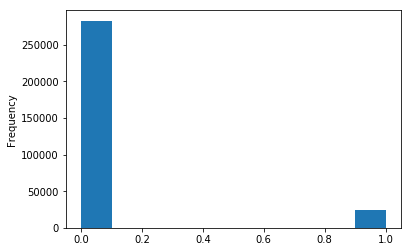

In [7]:
app_train['TARGET'].plot.hist()

From this information, we see this is an **imbalanced** class problem. There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can weight the classes by their representation in the data to reflect this imbalance.

### Examine Missing Values

In [8]:
# Function to calculate missing values by column
def missing_values_table(df):
    # Total missing values
    miss_val = app_train.isnull().sum()
    
    # Percentage of missing values
    miss_val_percent = (miss_val / len(df)) * 100
    
    # Make a table with the results
    miss_val_table = pd.concat([miss_val, miss_val_percent], axis = 1)
    
    # Rename the columns
    miss_val_table_ren_cols = miss_val_table.rename(columns = {0: 'Missing Values', 1: '% of Total Values'})
    
    # Sort (descending) the table by percentage of missing
    miss_val_table_ren_cols = miss_val_table_ren_cols[miss_val_table_ren_cols.iloc[:, 0] != 0]. \
                              sort_values('Missing Values', ascending = False).round(1)
    
    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n" + 
          "There are " + str(miss_val_table_ren_cols.shape[0]) + " columns that have missing values.")
    
    # Return the dataframe with missing information
    return miss_val_table_ren_cols

In [9]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


When it comes time to build our machine learning models, we will have to fill in these missing values (known as imputation).XGBoost can handle missing values with no need for imputation. Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. Therefore, we will keep all of the columns for now.

### Column Types
Let's look at the number of columns of each data type. int64 and float64 are numeric variables (which can be either discrete or continuous). object columns contain strings and are categorical features.

In [10]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [11]:
# Number of unique classes (categories) in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Most of the categorical variables have a relatively small number of unique classes (categories).

### Encoding Categorical Variables

A machine learning model unfortunately cannot deal with categorical variables (except for some models such as LightGBM). Therefore, we have to find a way to encode (represent) these variables as numbers before handing them off to the model. There are two main ways to carry out this process:

- **Label encoding**: assign each unique category in a categorical variable with an integer. No new columns are created.

- **One-hot encoding**: create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns.

The problem with label encoding is that it gives the categories an arbitrary ordering. The value assigned to each of the categories is random and does not reflect any inherent aspect of the category. When we perform label encoding, the model might use the relative value of the feature (for example programmer = 4 and data scientist = 1) to assign weights which is not what we want. If we only have two unique values for a categorical variable (such as Male/Female), then label encoding is fine, but for more than 2 unique categories, one-hot encoding is the safe option.

For categorical variables with many classes, one-hot encoding is the safest approach because it does not impose arbitrary values to categories. The only downside to one-hot encoding is that the number of features (dimensions of the data) can explode with categorical variables with many categories. To deal with this, we can perform one-hot encoding followed by PCA or other dimensionality reduction methods to reduce the number of dimensions (while still trying to preserve information).

Fore more details: https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor

### Label Encoding and One-Hot Encoding

Let's implement the policy described above: for any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding.

For label encoding, we use the Scikit-Learn **LabelEncoder** and for one-hot encoding, the pandas **get_dummies(df)** function.

In [12]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print("%d columns were label encoded." % le_count)

3 columns were label encoded.


In [13]:
# one-hot encoding of categorical variables  (having more than 2 unique categories)
app_train = pd.get_dummies(app_train) 
app_test = pd.get_dummies(app_test) 

print("Training Features Shape: ", app_train.shape)
print("Testing Features Shape: ", app_test.shape)

Training Features Shape:  (307511, 243)
Testing Features Shape:  (48744, 239)


### Aligning Training and Testing Data

There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to **align** the dataframes. First we extract the target column from the training data (because this is not in the testing data but we need to keep this information). When we do the align, we must make sure to set **axis = 1** to align the dataframes based on the columns and not on the rows.

In [14]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print("Training Features Shape: ", app_train.shape)
print("Testing Features Shape: ", app_test.shape)

Training Features Shape:  (307511, 240)
Testing Features Shape:  (48744, 239)


## Back to Exploratory Data Analysis

### Anomalies

One problem we always want to be on the lookout for when doing EDA is anomalies within the data. These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. One way to support anomalies quantitatively is by looking at the statistics of a column using the **describe** method. The numbers in the **DAYS_BIRTH** column are negative because they are recorded relative to the current loan application. To see these stats in years, we can mutliple by -1 and divide by the number of days in a year:

In [15]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Those ages look reasonable. There are no outliers for the age on either the high or low end.

In [16]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

That doesn't look right! The maximum value (besides being positive) is about 1000 years!

Text(0.5,0,'Days Employment')

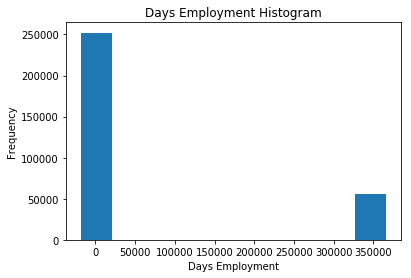

In [17]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')

let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients.

In [18]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]

print("The anomalies default on %0.2f%% of loans" % (100 * anom['TARGET'].mean()))
print("The non-anomalies default on %0.2f%% of loans" % (100 * non_anom['TARGET'].mean()))
print("There are %d anaomalous days of employment" %len(anom))

The anomalies default on 5.40% of loans
The non-anomalies default on 8.66% of loans
There are 55374 anaomalous days of employment


It turns out that the anomalies have a lower rate of default.

Handling the anomalies depends on the exact situation, with no set rules. One of the safest approaches is just to set the anomalies to a missing value and then have them filled in (using Imputation) before machine learning. In this case, since all the anomalies have the exact same value, we want to fill them in with the same value in case all of these loans share something in common. The anomalous values seem to have some importance, so we want to tell the machine learning model if we did in fact fill in these values. As a solution, we will fill in the anomalous values with not a number (np.nan) and then create a new boolean column indicating whether or not the value was anomalous.

Text(0.5,0,'Days Employment')

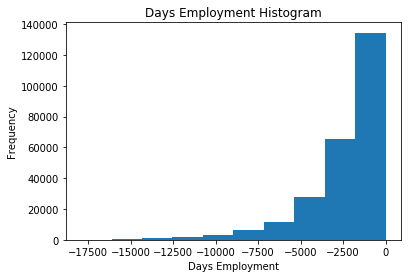

In [19]:
app_train['DAYS_EMPLOYED_ANOM'] = app_train['DAYS_EMPLOYED'] == 365243

app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')

The distribution looks to be much more in line with what we would expect, and we also have created a new column to tell the model that these values were originally anomalous (becuase we will have to fill in the nans with some value, probably the median of the column). The other columns with DAYS in the dataframe look to be about what we expect with no obvious outliers.

As an extremely important note, anything we do to the training data we also have to do to the testing data. Let's make sure to create the new column and fill in the existing column with np.nan in the testing data.

In [20]:
# if results are not valid, re-read the test dataset
app_test['DAYS_EMPLOYED_ANOM'] = app_test['DAYS_EMPLOYED'] == 365243
app_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

print("There are %d anomalies in the test data out of %d entries" %(app_test['DAYS_EMPLOYED_ANOM'].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


### Correlations

Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the **.corr** dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

- .00-.19 “very weak”
- .20-.39 “weak”
- .40-.59 “moderate”
- .60-.79 “strong”
- .80-1.0 “very strong”

In [21]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values(ascending = False)

# Display correlations
print("Most Positive Correlations:\n", correlations.head(15))
print("\nMost Negative Correlations:\n", correlations.tail(15))

Most Positive Correlations:
 TARGET                                               1.000000
DAYS_BIRTH                                           0.078239
DAYS_EMPLOYED                                        0.074958
REGION_RATING_CLIENT_W_CITY                          0.060893
REGION_RATING_CLIENT                                 0.058899
NAME_INCOME_TYPE_Working                             0.057481
DAYS_LAST_PHONE_CHANGE                               0.055218
CODE_GENDER_M                                        0.054713
DAYS_ID_PUBLISH                                      0.051457
REG_CITY_NOT_WORK_CITY                               0.050994
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
FLAG_EMP_PHONE                                       0.045982
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_DOCUMENT_3                                      0.044346
OCCUPATION_TYPE_Laborers                             0.043019
Name: TARGET, dtype: float64

Most Negati

### Effect of Age on Repayment

In [22]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982709

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often.

Let's start looking at this variable. First, we can make a histogram of the age. We will put the x axis in years to make the plot a little more understandable.

Text(0,0.5,'Count')

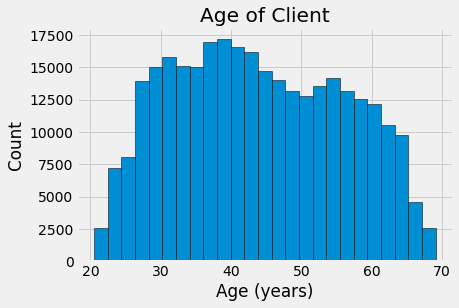

In [23]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client')
plt.xlabel('Age (years)')
plt.ylabel('Count')

By itself, the distribution of age does not tell us much other than that there are no outliers as all the ages are reasonable. To visualize the effect of the age on the target, we will next make a kernel density estimation plot (KDE) colored by the value of the target. A kernel density estimate plot shows the distribution of a single variable and can be thought of as a smoothed histogram (it is created by computing a kernel, usually a Gaussian, at each data point and then averaging all the individual kernels to develop a single smooth curve). We will use the seaborn kdeplot for this graph.

Text(0,0.5,'Density')

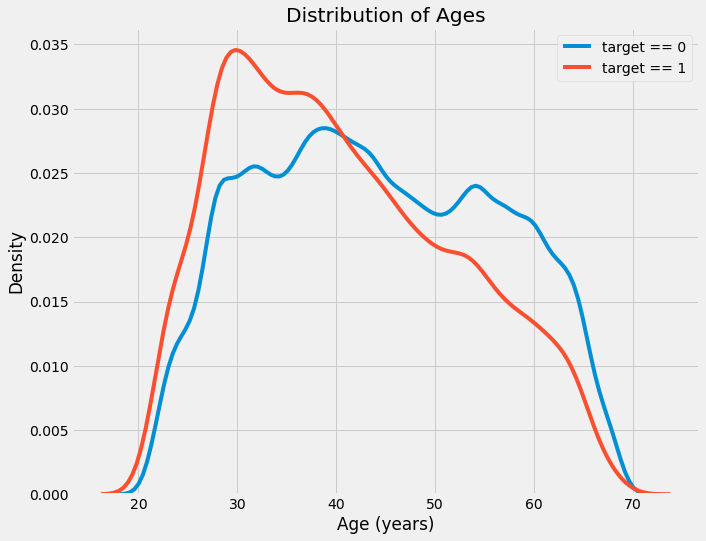

In [24]:
# KDE (Kernel Density Estimation) Plot

plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')
# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.title('Distribution of Ages')
plt.xlabel('Age (years)')
plt.ylabel('Density')

The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket.

To make this graph, first we **cut** the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [25]:
# Age information into a separate dataframe
age_data = app_train[['DAYS_BIRTH', 'TARGET']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,DAYS_BIRTH,TARGET,YEARS_BIRTH,YEARS_BINNED
0,9461,1,25.920548,"(25.0, 30.0]"
1,16765,0,45.931507,"(45.0, 50.0]"
2,19046,0,52.180822,"(50.0, 55.0]"
3,19005,0,52.068493,"(50.0, 55.0]"
4,19932,0,54.608219,"(50.0, 55.0]"
5,16941,0,46.413699,"(45.0, 50.0]"
6,13778,0,37.747945,"(35.0, 40.0]"
7,18850,0,51.643836,"(50.0, 55.0]"
8,20099,0,55.065753,"(55.0, 60.0]"
9,14469,0,39.641096,"(35.0, 40.0]"


In [26]:
# Group by the bin and calculate averages
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

,DAYS_BIRTH,TARGET,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",8532.795625,0.123036,23.377522
"(25.0, 30.0]",10155.219250,0.111436,27.822518
"(30.0, 35.0]",11854.848377,0.102814,32.479037
"(35.0, 40.0]",13707.908253,0.089414,37.555913
"(40.0, 45.0]",15497.661233,0.078491,42.459346
"(45.0, 50.0]",17323.900441,0.074171,47.462741
"(50.0, 55.0]",19196.494791,0.066968,52.593136
"(55.0, 60.0]",20984.262742,0.055314,57.491131
"(60.0, 65.0]",22780.547460,0.052737,62.412459


Text(0.5,1,'Failure to Repay by Age Group')

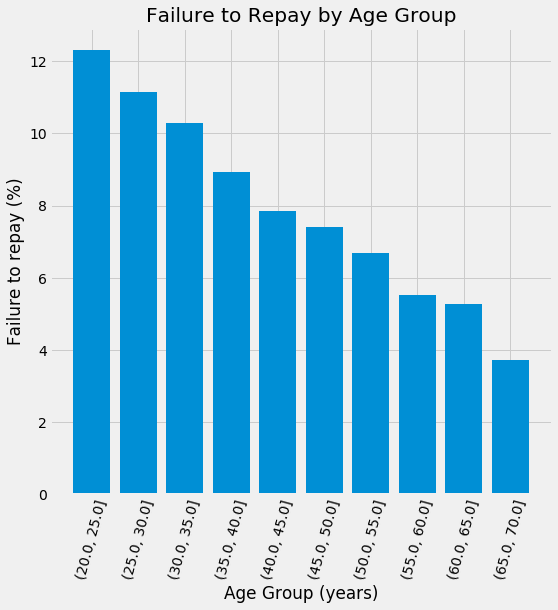

In [27]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), age_groups['TARGET'] * 100)

# Plot labeling
plt.xticks(rotation = 75)
plt.xlabel('Age Group (years)')
plt.ylabel('Failure to repay (%)')
plt.title('Failure to Repay by Age Group')

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

### Exterior Sources

The 3 variables with the strongest negative correlations with the target are **EXT_SOURCE_1**, **EXT_SOURCE_2**, and **EXT_SOURCE_3**. According to the documentation, these features represent a "normalized score from external data source".

Let's take a look at these variables.

First, we can show the correlations of the EXT_SOURCE features with the target and with each other.

In [28]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


Text(0.5,1,'Correlation HeatMap')

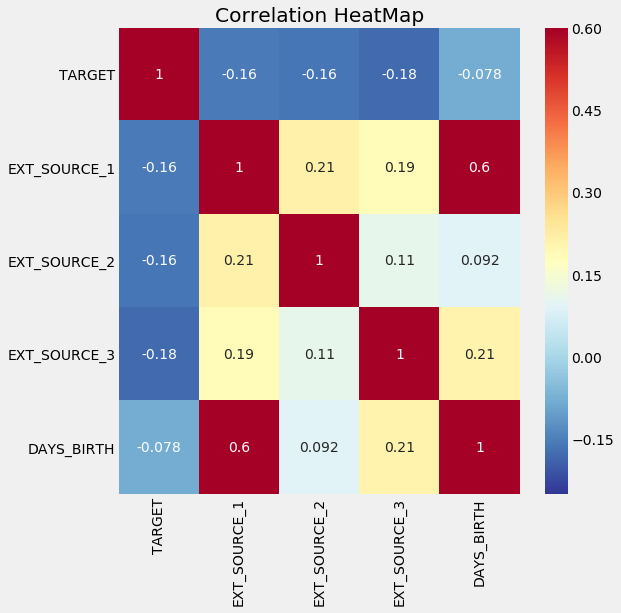

In [29]:
plt.figure(figsize = (8, 8))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, vmax = 0.6, annot = True)
plt.title("Correlation HeatMap")

All three **EXT_SOURCE** featureshave negative correlations with the target, indicating that as the value of the **EXT_SOURCE** increases, the client is more likely to repay the loan. We can also see that **DAYS_BIRTH** is positively correlated with **EXT_SOURCE_1** indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.

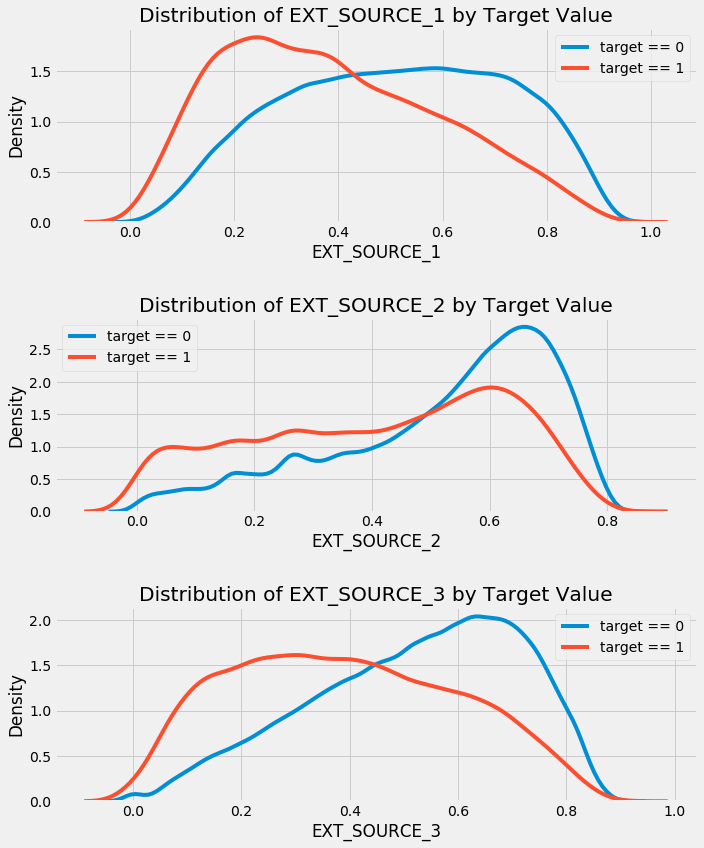

In [30]:
plt.figure(figsize = (10, 12))
ext_sources = 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'

# iterate through the sources
for i, source in enumerate(ext_sources):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title("Distribution of %s by Target Value" %source)
    plt.xlabel('%s' %source)
    plt.ylabel('Density')
    
plt.tight_layout(h_pad = 2.5)

**EXT_SOURCE_3** displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all considered very weak, but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

### Pairs Plot

As a final exploratory plot, we can make a pairs plot of the **EXT_SOURCE** variables and the **DAYS_BIRTH** variable. The Pairs Plot is a great exploration tool because it lets us see relationships between multiple pairs of variables as well as distributions of single variables. Here we are using the seaborn visualization library and the PairGrid function to create a Pairs Plot with scatterplots on the upper triangle, histograms on the diagonal, and 2D kernel density plots and correlation coefficients on the lower triangle.

C:\Users\VenD\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\Users\VenD\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\Users\VenD\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\Users\VenD\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\Users\VenD\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\Users\VenD\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\Users\VenD\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The followin

Text(0.5,1.05,'Ext Source and Age Features Pairs Plot')

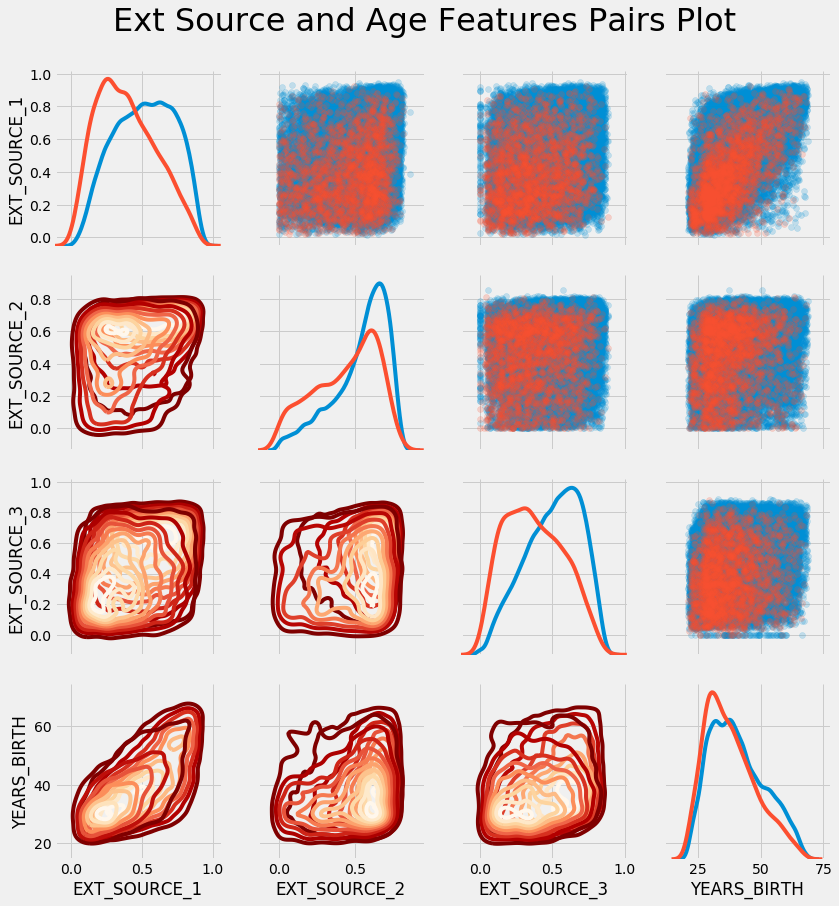

In [31]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, hue = 'TARGET', size = 3, diag_sharey = False, 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r)

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05)

In this plot, the red indicates loans that were not repaid and the blue are loans that are paid. We can see the different relationships within the data. There does appear to be a moderate positive linear relationship between the **EXT_SOURCE_1** and the **DAYS_BIRTH** (or equivalently **YEARS_BIRTH**), indicating that this feature may take into account the age of the client.

### Feature Engineering

While choosing the right model and optimal settings are important, the model can only learn from the data it is given. Making sure this data is as relevant to the task as possible is the job of the data scientist (and maybe some automated tools to help us out).

Feature engineering refers to a geneal process and can involve both feature construction: adding new features from the existing data, and feature selection: choosing only the most important features or other methods of dimensionality reduction. There are many techniques we can use to both create features and select features.

Two simple feature construction methods:

- Polynomial features
- Domain knowledge features

### Polynomial Features

One simple feature construction method is called polynomial features. In this method, we make features that are powers of existing features as well as interaction terms between existing features. For example, we can create variables **EXT_SOURCE_1^2** and **EXT_SOURCE_2^2** and also variables such as **EXT_SOURCE_1** x **EXT_SOURCE_2**, **EXT_SOURCE_1** x **EXT_SOURCE_2^2**, **EXT_SOURCE_1^2** x  **EXT_SOURCE_2^2**, and so on. These features that are a combination of multiple individual variables are called **interaction terms** because they capture the interactions between variables. In other words, while two variables by themselves may not have a strong influence on the target, combining them together into a single interaction variable might show a relationship with the target.

We create polynomial features using the **EXT_SOURCE** variables and the **DAYS_BIRTH** variable. Scikit-Learn has a useful class called **PolynomialFeatures** that creates the polynomials and the interaction terms up to a specified degree. We can use a degree of 3 to see the results (when we are creating polynomial features, we want to avoid using too high of a degree, both because the number of features scales exponentially with the degree, and because we can run into problems with **overfitting**).

In [32]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
poly_target = app_train['TARGET']

poly_test_features = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_test_features = imputer.transform(poly_test_features)

In [33]:
from sklearn.preprocessing import PolynomialFeatures

# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_test_features = poly_transformer.transform(poly_test_features)
print("Polynomial Features Shape: ", poly_features.shape)

Polynomial Features Shape:  (307511, 35)


In [34]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

There are 35 features with individual features raised to powers up to degree 3 and interaction terms. Now, we can see whether any of these new features are correlated with the target.

In [35]:
poly_feature_names = poly_transformer.get_feature_names(input_features = 
                                                        ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

# Create a dataframe of the features
poly_features = pd.DataFrame(poly_features, columns = poly_feature_names)

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(10))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
EXT_SOURCE_1                -0.098887
EXT_SOURCE_1^2 DAYS_BIRTH   -0.097507
EXT_SOURCE_1 DAYS_BIRTH^2   -0.094913
EXT_SOURCE_1^2              -0.091034
EXT_SOURCE_1^3              -0.083005
DAYS_BIRTH                  -0.078239
DAYS_BIRTH^2                -0.076672
DAYS_BIRTH^3                -0.074273
TARGET                       1.000000
1                                 NaN
Name: TARGET, dtype: float64


Several of the new variables have a greater (in terms of absolute magnitude) correlation with the target than the original features. When we build machine learning models, we can try with and without these features to determine if they actually help the model learn.

We will add these features to a copy of the training and testing data and then evaluate models with and without the features. Many times in machine learning, the only way to know if an approach will work is to try it out!

In [37]:
def drop_y(df):
    # list comprehension of the cols that end with '_y'
    to_drop = [x for x in df if x.endswith('_y')]
    df.drop(to_drop, axis=1, inplace=True)

In [38]:
poly_feature_names = poly_transformer.get_feature_names(input_features = 
                                                        ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

# Put test features into dataframe
poly_test_features = pd.DataFrame(poly_test_features, columns = poly_feature_names)

# Note: merge duplicates the columns (be careful of that)

poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
# Merge polynomial features into training dataframe
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')
# drop duplicate columns
drop_y(app_train_poly)

poly_test_features['SK_ID_CURR'] = app_test['SK_ID_CURR']
# Merge polnomial features into testing dataframe
app_test_poly = app_test.merge(poly_test_features, on = 'SK_ID_CURR', how = 'left')
# drop duplicate columns
drop_y(app_test_poly)

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print("Training data with Polynomial features shape: ", app_train_poly.shape)
print("Testing data with Polynomial features shape: ", app_test_poly.shape)

Training data with Polynomial features shape:  (307511, 271)
Testing data with Polynomial features shape:  (48744, 271)


### Domain Knowledge Features

We could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here, we will use these features by applying domian knowledge,

- **CREDIT_INCOME_PERCENT**: the percentage of the credit amount relative to a client's income
- **ANNUITY_INCOME_PERCENT**: the percentage of the loan annuity relative to a client's income
- **CREDIT_TERM**: the length of the payment in months (since the annuity is the monthly amount due
- **DAYS_EMPLOYED_PERCENT**: the percentage of the days employed relative to the client's age

In [39]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [40]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

### Visualize New Variables

For all domain knowledge features, we will make the same KDE plot colored by the value of the TARGET.

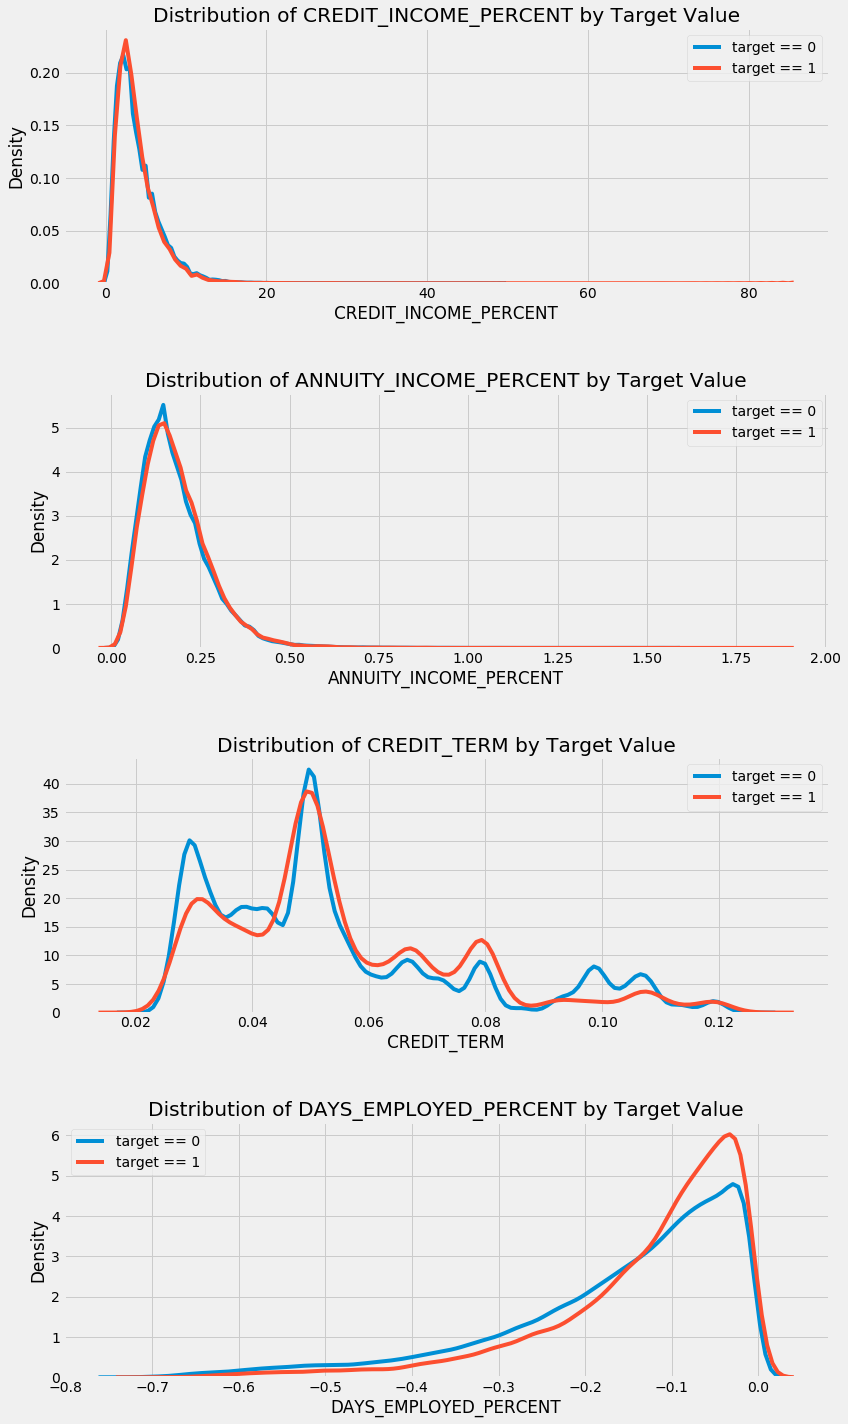

In [41]:
plt.figure(figsize = (12, 20))

features = ['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']

# iterate through the new features
for i, feature in enumerate(features):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' %feature)
    plt.xlabel('%s' %feature)
    plt.ylabel('Density')

plt.tight_layout(h_pad = 3.5)

### Baseline

For a naive baseline, we could guess the same value for all examples on the testing set. We are asked to predict the probability of not repaying the loan, so if we are entirely unsure, we would guess 0.5 for all observations on the test set. This will get us a Reciever Operating Characteristic Area Under the Curve (AUC ROC) of 0.5 in the competition (random guessing on a classification task will score a 0.5).

Since we already know what score we are going to get, we don't really need to make a naive baseline guess. Let's use a slightly more sophisticated model for our actual baseline: Logistic Regression.

### Logistic Regression Implementation

To get a baseline, we will use all of the features after encoding the categorical variables. We will preprocess the data by filling in the missing values (imputation) and normalizing the range of the features (feature scaling). The following code performs both of these preprocessing steps.

In [42]:
from sklearn.preprocessing import Imputer, MinMaxScaler

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
scaler.fit(train)

# Transform both training and testing data
train = scaler.transform(train)
test = scaler.transform(test)

# print data summary
print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


Only change we will make from the default model settings is to lower the regularization parameter, C, which controls the amount of overfitting (a lower value should decrease overfitting). This will get us slightly better results than the default LogisticRegression, but it still will set a low bar for any future models.

Here we use the familiar Scikit-Learn modeling syntax: we first create the model, then we train the model using **.fit** and then we make predictions on the testing data using **.predict_proba** (remember that we want probabilities and not a 0 or 1).

In [43]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
logistic_regression = LogisticRegression(C = 0.0001)

# Train on the training data
logistic_regression.fit(train, train_labels)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [44]:
# Make predictions
predictions = logistic_regression.predict_proba(test)

In [47]:
def make_submission(predictions, sub_no):
    try:
        # submission file path
        submit_path = 'E:/Kaggle/home-credit-default-risk/datasets/submission_' + str(sub_no) + '.csv'
        # make submission dataframe by extracting 2nd column of predictions
        submit = pd.DataFrame({'SK_ID_CURR': app_test['SK_ID_CURR'], 'TARGET': predictions[:, 1]})
        # write submission dataframe to csv
        submit.to_csv(submit_path, index = False)
        # submission successful
        print("Submission File create successfully!")
    except:
        print("Something went wrong while creating submission file.")

In [188]:
make_submission(predictions, 1)

Submission File create successfully!


### Improved Model: Random Forest

To try and beat the poor performance of our baseline, we can update the algorithm. Let's try using a Random Forest on the same training data to see how that affects performance. The Random Forest is a much more powerful model especially when we use hundreds of trees. We will use 100 trees in the random forest.

In [48]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# Train on the training data
random_forest.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   45.8s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=50, verbose=1, warm_start=False)

In [49]:
# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(test)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


In [190]:
make_submission(predictions, 2)

Submission File create successfully!


### Make Predictions using Engineered Features

The only way to see if the Polynomial Features and Domain knowledge improved the model is to train a test a model on these features! We can then compare the submission performance to that for the model without these features to gauge the effect of our feature engineering.

In [51]:
poly_features_names = list(app_train_poly.columns)

# Impute the polynomial features
imputer = Imputer(strategy = 'median')

poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

# Scale the polynomial features
scaler = MinMaxScaler(feature_range = (0, 1))

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

In [52]:
# Make the random forest classifier
random_forest_poly = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# Train on the training data
random_forest_poly.fit(poly_features, train_labels)

# Make predictions on the test data
predictions = random_forest_poly.predict_proba(poly_features_test)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [225]:
make_submission(predictions, 5)

Submission File create successfully!


### Testing Domain Features
Now we can test the domain features we made by hand.

In [53]:
app_train_domain = app_train_domain.drop(columns = ['TARGET'])

domain_feature_names = list(app_train_domain.columns)

# Impute the domain knowledge features
imputer = Imputer(strategy = 'median')

domain_features = imputer.fit_transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

# Scale the domain knowledge features
scaler = MinMaxScaler(feature_range = (0, 1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

In [54]:
random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

random_forest_domain.fit(domain_features, train_labels)

predictions = random_forest_domain.predict_proba(domain_features_test)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   46.5s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


In [55]:
feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_feature_names, 'importance': feature_importance_values_domain})

In [231]:
make_submission(predictions, 6)

Submission File create successfully!


### Model Interpretation: Feature Importances

In [56]:
def plot_feature_importances(df):
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    
    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot, most important on top
    ax.barh(list(reversed(list(df.index[:15]))), df['importance_normalized'].head(15), align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance')
    plt.title('Feature Importances')
    
    plt.show()
    
    return df

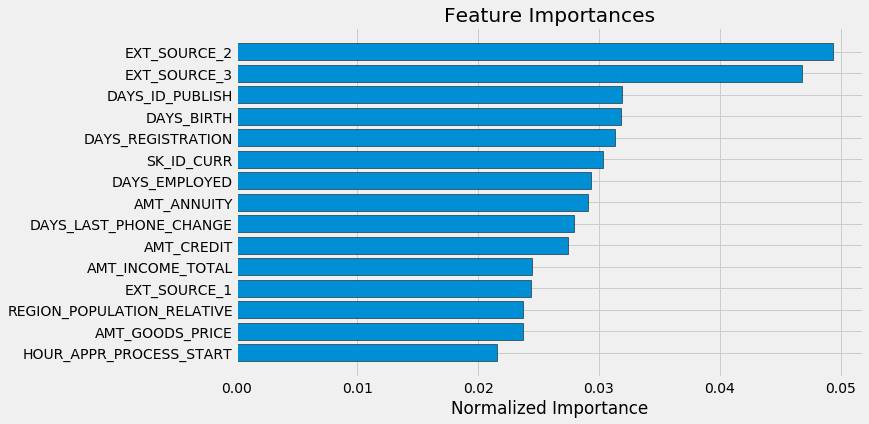

In [57]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

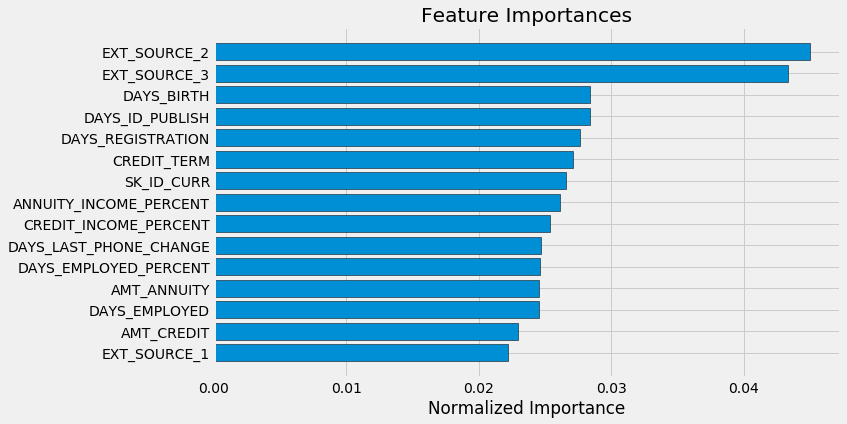

In [58]:
# Show the feature importances for the domain knowledge features
feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)

In [59]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    # extract train and test ID's
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # extract labels from train data
    labels = features['TARGET']
    
    # drop ID from train and test and also target from train
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    # in case of one-hot encoding
    if encoding == 'ohe':
        
        # make one-hot feature for each categorical feature
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        cat_indices = 'auto'
        
    # in case of label encoding    
    elif encoding == 'le':
        
        label_encoder = LabelEncoder()
        
        cat_indices = []
        
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # convert categorical features to label encoding features for both train and test set
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1, )))
                test_features[col] = label_encoder.fit_transform(np.array(test_features[col].astype(str)).reshape((-1, )))
                # keep track of categorical feature indices
                cat_indices.append(i)
                
        else:
            raise ValueError("Encoding must be either 'ohe' or 'le'")
            
    # print summary
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # extract feature names
    feature_names = list(features.columns)
    
    # convert train and test data into numpy arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # make KFold object with given no. of splits
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    feature_importance_values = np.zeros(len(feature_names))

    test_predictions = np.zeros(test_features.shape[0])
    
    out_of_fold = np.zeros(features.shape[0])
    
    # lists for tracking score of each fold (train and test dataset)
    valid_scores = []
    train_scores = []
    
    # iterate through all folds
    for train_indices, valid_indices in k_fold.split(features):
        # make train fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # make valid fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # make LightGBM object with customized parameters
        model = lgb.LGBMClassifier(n_estimators = 10000, objective = 'binary', class_weight = 'balanced',
                                   learning_rate = 0.05, reg_alpha = 0.1, reg_lambda = 0.1, subsample = 0.8,
                                   n_jobs = -1, random_state = 50)
        
        # train LightGBM on train data and evaluate on both train and valid set
        model.fit(train_features, train_labels, eval_metric = 'auc', 
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # keep track of best iteration during training
        best_iteration = model.best_iteration_
        
        # cumulative feature importances of all folds
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # cumulative test predictions of all folds
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # valid predictions of all folds
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # best accuracy score on train and valid set for each fold
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        # keep track of all train and valid best scores
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # make submission dataframe (id and predictions)
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # make feature importance dataframe (feature and importance)
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # evaluate roc_auc score on valid set predictions
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # overall train and valid score
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # list of folds
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # dataframe of metrics
    metrics = pd.DataFrame({
                'fold': fold_names,
                'train': train_scores,
                'valid': valid_scores
              })
    
    return submission, feature_importances, metrics

In [60]:
submission, fi, metrics = model(app_train, app_test)
print('\nBaseline metrics')
print(metrics)

Training Data Shape:  (307511, 239)
Testing Data Shape:  (48744, 239)
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.547648	train's auc: 0.79887	valid's binary_logloss: 0.563125	valid's auc: 0.754949
Early stopping, best iteration is:
[208]	train's binary_logloss: 0.546264	train's auc: 0.80025	valid's binary_logloss: 0.562276	valid's auc: 0.755109
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.548144	train's auc: 0.798518	valid's binary_logloss: 0.563479	valid's auc: 0.758539
Early stopping, best iteration is:
[217]	train's binary_logloss: 0.545314	train's auc: 0.801374	valid's binary_logloss: 0.561732	valid's auc: 0.758619
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.54923	train's auc: 0.79774	valid's binary_logloss: 0.564246	valid's auc: 0.762652
[400]	train's binary_logloss: 0.520152	train's auc: 0.827288	valid's binary_logloss: 0.546576	v

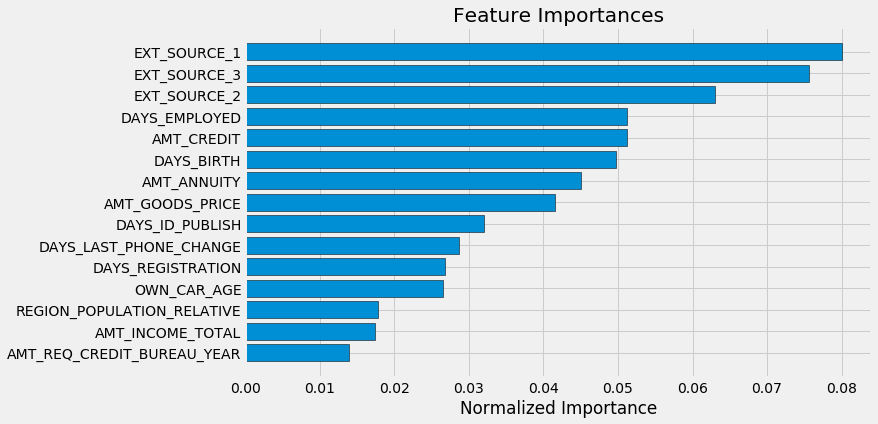

In [61]:
# Show the feature importances for the default features using LightGBM
fi_sorted = plot_feature_importances(fi)

In [268]:
submission.to_csv('E:/Kaggle/home-credit-default-risk/datasets/submission_7.csv', index = False)

In [62]:
app_train_domain['TARGET'] = train_labels

submission, fi, metrics = model(app_train_domain, app_test_domain)
print('\nBaseline with domain knowledge feature metrics')
print(metrics)

Training Data Shape:  (307511, 243)
Testing Data Shape:  (48744, 243)
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.541661	train's auc: 0.804531	valid's binary_logloss: 0.557281	valid's auc: 0.762577
Early stopping, best iteration is:
[237]	train's binary_logloss: 0.535426	train's auc: 0.810671	valid's binary_logloss: 0.553438	valid's auc: 0.762858
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.542018	train's auc: 0.804304	valid's binary_logloss: 0.55808	valid's auc: 0.765594
Early stopping, best iteration is:
[227]	train's binary_logloss: 0.537574	train's auc: 0.808665	valid's binary_logloss: 0.555268	valid's auc: 0.765861
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.542936	train's auc: 0.803753	valid's binary_logloss: 0.557892	valid's auc: 0.770139
[400]	train's binary_logloss: 0.511693	train's auc: 0.834338	valid's binary_logloss: 0.53839

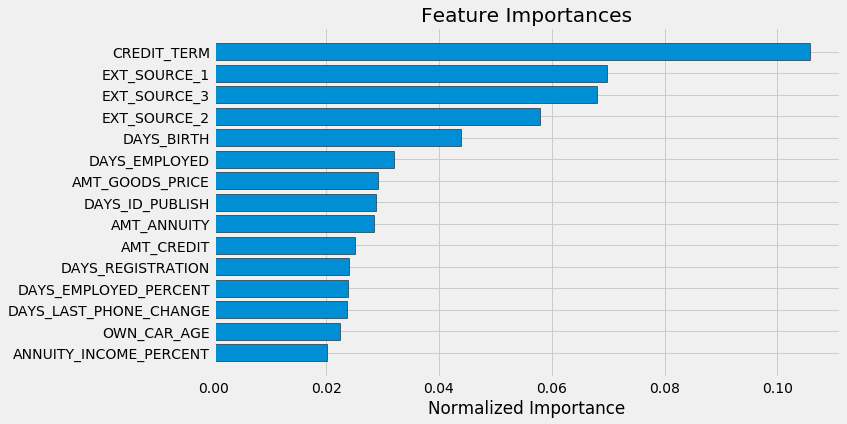

In [63]:
# Show the feature importances for the domain knowledge features using LightGBM
fi_sorted = plot_feature_importances(fi)

In [271]:
submission.to_csv('E:/Kaggle/home-credit-default-risk/datasets/submission_8.csv', index = False)